In [1]:
%load_ext autoreload
%autoreload 2
# %cd 'python/AggNet'
%ls

'AggNet: Advancing protein aggregation analysis through deep learning and protein language model - He.html'
 APNet_CPAD2_20aa_results.csv
 APNet_CPAD2_6aa_results.csv
 APNet_CPAD2_results.csv
 APNet_results.csv
 APRNet_results.csv
 checkpoint/
 CPAD2_combined_predictions.csv
 CPAD2.ipynb
 CPAD2_length_comparison.png
 CPAD2_length_stratified_metrics.csv
 CPAD2_overall_comparison.png
 CPAD2_overall_metrics.csv
 CPAD2_roc_curves.png
 data/
 example.ipynb
 lightning_logs/
 lightning_logs_og/
 model/
 NNK_TRAINING_GUIDE.md
 ProjectStructure.md
 README.md
 script/
 utils/


# CPAD2 Dataset Analysis: APNet Model Comparison

This notebook compares two versions of APNet:
1. **APNet_6aa**: Trained on 6-aa sequences
2. **APNet_20aa**: Trained on 20-aa sequences (Thompson dataset)

Both models are evaluated on the CPAD2 aggregating peptides dataset.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from utils.file import write_fasta

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

==================== add root_path to sys.path ====================
root_path: /nobackup/autodelete/usr/ssgardin/AggNet


## 1. Load and Prepare CPAD2 Dataset

In [3]:
df = pd.read_excel('./data/CPAD2/aggregating peptides.xlsx')
print(f"Total samples: {len(df)}")
print(f"\nClassification distribution:")
print(df['Classification'].value_counts())
df.head()

Total samples: 2031

Classification distribution:
Classification
Non-amyloid    1055
Amyloid         716
amyloid         201
non-amyloid      59
Name: count, dtype: int64


,Entry,Peptide,Length,Classification,Uniprot Entry Name,Uniprot ID,Protein Name,Position,% Helix (PASTA 2.0),% Beta Strand (PASTA 2.0),...,Tango,% Disorder (PASTA 2.0),Best Energy Score (PASTA 2.0),Aggregate Orientation (PASTA 2.0),Mutant,Protein Sequence,Amyloid Structure,Reference,PMID,"Source (Waltz-DB,CPAD,AmyLoad,Waltz)"
0,P-0001,GYE,3,Amyloid,A4_HUMAN,P05067,Amyloid-beta precursor protein (APP),680-682,0.0,0.0,...,0.0,100.0,10000.000000,Antiparallel,No,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,No structures,Org Lett. 2008 Jul 3;10(13):2625-8.,18529009,CPAD
1,P-0002,KFFE,4,Amyloid,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,100.0,-2.222498,Antiparallel,NaN,NaN,No structures,J Biol Chem. 2002 Nov 8;277(45):43243-6.,12215440,CPAD
2,P-0003,KVVE,4,Amyloid,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,100.0,-2.838181,Antiparallel,NaN,NaN,No structures,J Biol Chem. 2002 Nov 8;277(45):43243-6.,12215440,CPAD
3,P-0004,NNQQ,4,Amyloid,ERF3_YEAST,P05453,Eukaryotic peptide chain release factor GTP-bi...,8-11,0.0,0.0,...,0.0,100.0,1.802299,Antiparallel,NaN,MSDSNQGNNQQNYQQYSQNGNQQQGNNRYQGYQAYNAQAQPAGGYY...,No structures,Nature. 2007 May 24;447(7143):453-7.,17468747,CPAD
4,P-0005,VKSE,4,Non-amyloid,TAU_HUMAN,P10636,Microtubule-associated protein tau (PHF-tau),NaN,0.0,0.0,...,0.0,100.0,0.586433,Antiparallel,NaN,NaN,No structures,Proc Natl Acad Sci U S A. 2000 May 9;97(10):51...,10805776,AmyLoad


In [4]:
sequences = df['Peptide'].values

text2label = {
    'Amyloid': 1,
    'amyloid': 1,
    'Non-amyloid': 0,
    'non-amyloid': 0
}
labels = df['Classification'].apply(lambda x: text2label[x]).values
entries = df['Entry'].values

is_amyloid = {
    1: 'amyloid',
    0: 'non-amyloid'
}
headers = [f'{entry}, {is_amyloid[label]}, label={label}' for entry, label in zip(entries, labels)]

# Save FASTA for predictions
path = './data/CPAD2/CPAD2.fasta'
write_fasta(path, sequences, headers)
print(f"Saved {len(sequences)} sequences to {path}")

Saved 2031 sequences to ./data/CPAD2/CPAD2.fasta


In [5]:
CPAD2_df = df[['Peptide', 'Classification']].copy()
CPAD2_df['Classification'] = CPAD2_df['Classification'].apply(lambda x: text2label[x])
CPAD2_df.columns = ['peptide', 'label']
CPAD2_df['length'] = CPAD2_df['peptide'].apply(len)
print(f"\nSequence length distribution:")
print(CPAD2_df['length'].value_counts().sort_index())
CPAD2_df


Sequence length distribution:
length
3        1
4        4
5       16
6     1422
7       50
8       35
9       24
10     133
11      21
12      21
13      18
14      20
15      24
16      26
17      13
18      26
19      11
20      18
21      14
22      16
23       5
24       6
25       7
26       6
27       1
28      11
29       7
30       2
31       4
32       2
33       3
34       3
35       4
36       3
37       1
39       1
40      29
42      10
43       1
44       2
48       1
51       2
53       1
55       1
56       1
65       1
71       1
79       1
83       1
Name: count, dtype: int64


,peptide,label,length
0,GYE,1,3
1,KFFE,1,4
2,KVVE,1,4
3,NNQQ,1,4
4,VKSE,0,4
...,...,...,...
2026,GQGGGTHNQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYMLGSAMS...,1,56
2027,GQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGG...,1,65
2028,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ...,1,71
2029,GKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTA...,1,79


## 2. Run Predictions for Both Models

Execute the cells below to generate predictions from both APNet models.

In [6]:
import subprocess

print("Running APNet_6aa predictions...")
result = subprocess.run([
    "python", "script/predict_amyloid.py",
    "--fasta", "./data/CPAD2/CPAD2.fasta",
    "--checkpoint", "./checkpoint/APNet.ckpt",
    "--batch_size", "256",
    "--output", "./APNet_CPAD2_6aa_results.csv"
], capture_output=True, text=True)

print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)
if result.returncode == 0:
    print("✓ APNet_6aa predictions completed successfully!")
else:
    print(f"✗ Command failed with return code {result.returncode}")

Running APNet_6aa predictions...
==================== add root_path to sys.path ====================
root_path: /nobackup/autodelete/usr/ssgardin/AggNet
[loading checkpoint]: ./checkpoint/APNet.ckpt
[prepare custom predict dataset] 2031
============================== Setup [predict] Start ==============================
[self.predict_dataset] 2031
============================== Setup [predict] End ==============================
  0%|          | 0/8 [00:00<?, ?it/s]
[Warning]: Cannot concatenate tensor along dimension 0 for key loss
[Warning]: Cannot concatenate tensor along dimension 0 for key tokens

Results saved to ./APNet_CPAD2_6aa_results.csv

                                                peptide  ...        label
0                                                   GYE  ...  non-amyloid
1                                                  KFFE  ...  non-amyloid
2                                                  KVVE  ...      amyloid
3                                               

In [19]:
print("Running APNet_20aa predictions...")
result = subprocess.run([
    "python", "script/predict_amyloid.py",
    "--fasta", "./data/CPAD2/CPAD2.fasta",
    "--checkpoint", "./checkpoint/last_nodup.ckpt",
    "--batch_size", "256",
    "--output", "./APNet_CPAD2_20aa_results.csv"
], capture_output=True, text=True)

print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)
if result.returncode == 0:
    print("✓ APNet_20aa predictions completed successfully!")
else:
    print(f"✗ Command failed with return code {result.returncode}")

Running APNet_20aa predictions...
==================== add root_path to sys.path ====================
root_path: /nobackup/autodelete/usr/ssgardin/AggNet
[loading checkpoint]: ./checkpoint/last_nodup.ckpt
[prepare custom predict dataset] 2031
============================== Setup [predict] Start ==============================
[self.predict_dataset] 2031
============================== Setup [predict] End ==============================
  0%|          | 0/8 [00:00<?, ?it/s]
[Warning]: Cannot concatenate tensor along dimension 0 for key loss
[Warning]: Cannot concatenate tensor along dimension 0 for key tokens

Results saved to ./APNet_CPAD2_20aa_results.csv

                                                peptide  ...        label
0                                                   GYE  ...  non-amyloid
1                                                  KFFE  ...  non-amyloid
2                                                  KVVE  ...  non-amyloid
3                                        

## 3. Load and Process Predictions

In [20]:
def load_predictions(csv_path, model_name):
    """Load predictions and add model identifier"""
    pred_df = pd.read_csv(csv_path)
    pred_df['pred'] = pred_df['probability'].apply(lambda x: 1 if x > 0.5 else 0)
    pred_df = pred_df.drop(columns=['label'], errors='ignore')
    pred_df['model'] = model_name
    return pred_df

# Load predictions from both models
pred_6aa = load_predictions('./APNet_CPAD2_6aa_results.csv', 'APNet_6aa')
pred_20aa = load_predictions('./APNet_CPAD2_20aa_results.csv', 'APNet_20aa')

print("Predictions loaded:")
print(f"  APNet_6aa: {len(pred_6aa)} sequences")
print(f"  APNet_20aa: {len(pred_20aa)} sequences")

Predictions loaded:
  APNet_6aa: 2031 sequences
  APNet_20aa: 2031 sequences


In [21]:
merge_6aa = pd.merge(CPAD2_df, pred_6aa, on='peptide', how='inner')
merge_20aa = pd.merge(CPAD2_df, pred_20aa, on='peptide', how='inner')

print(f"\nAPNet_6aa merged: {len(merge_6aa)} sequences")
print(f"APNet_20aa merged: {len(merge_20aa)} sequences")
merge_6aa.head()


APNet_6aa merged: 2030 sequences
APNet_20aa merged: 2030 sequences


,peptide,label,length,probability,pred,model
0,GYE,1,3,0.329107,0,APNet_6aa
1,KFFE,1,4,0.182013,0,APNet_6aa
2,KVVE,1,4,0.519902,1,APNet_6aa
3,NNQQ,1,4,0.222988,0,APNet_6aa
4,VKSE,0,4,0.134442,0,APNet_6aa


## 4. Define Evaluation Functions

In [22]:
def evaluate_model(df, model_name):
    """Compute comprehensive metrics for model predictions"""
    # Check if we have both classes
    unique_labels = df['label'].unique()
    unique_preds = df['pred'].unique()
    
    results = {
        'model': model_name,
        'n_samples': len(df),
    }
    
    # Only compute metrics if we have predictions
    if len(unique_labels) > 1 and len(unique_preds) > 0:
        results['accuracy'] = accuracy_score(df['label'], df['pred'])
        results['precision'] = precision_score(df['label'], df['pred'], zero_division=0)
        results['recall'] = recall_score(df['label'], df['pred'], zero_division=0)
        results['f1_score'] = f1_score(df['label'], df['pred'], zero_division=0)
        results['auc'] = roc_auc_score(df['label'], df['probability'])
        
        # Confusion matrix - handle cases with only one class
        cm = confusion_matrix(df['label'], df['pred'])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        elif len(unique_labels) == 1 and unique_labels[0] == 0:
            # Only negative class
            tn = cm[0, 0] if len(unique_preds) == 1 and unique_preds[0] == 0 else 0
            fp = cm[0, 0] if len(unique_preds) == 1 and unique_preds[0] == 1 else 0
            fn = 0
            tp = 0
        else:
            # Only positive class or other edge case
            tn = 0
            fp = 0
            fn = cm[0, 0] if len(unique_preds) == 1 and unique_preds[0] == 0 else 0
            tp = cm[0, 0] if len(unique_preds) == 1 and unique_preds[0] == 1 else 0
        
        results['true_neg'] = tn
        results['false_pos'] = fp
        results['false_neg'] = fn
        results['true_pos'] = tp
        results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        # Not enough data for meaningful metrics
        results['accuracy'] = None
        results['precision'] = None
        results['recall'] = None
        results['f1_score'] = None
        results['auc'] = None
        results['true_neg'] = 0
        results['false_pos'] = 0
        results['false_neg'] = 0
        results['true_pos'] = 0
        results['specificity'] = None
    
    return results

def evaluate_by_length(df, model_name):
    """Evaluate model performance stratified by sequence length"""
    length_results = []
    
    for length in sorted(df['length'].unique()):
        temp_df = df[df['length'] == length]
        if len(temp_df) > 0:
            result = evaluate_model(temp_df, model_name)
            result['length'] = length
            length_results.append(result)
    
    return pd.DataFrame(length_results)

## 5. Overall Performance Comparison

In [23]:
print("="*70)
print("OVERALL PERFORMANCE COMPARISON")
print("="*70)

overall_results = []
overall_results.append(evaluate_model(merge_6aa, 'APNet_6aa'))
overall_results.append(evaluate_model(merge_20aa, 'APNet_20aa'))

overall_df = pd.DataFrame(overall_results)
print("\n")
print(overall_df[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'auc']].to_string(index=False))

OVERALL PERFORMANCE COMPARISON


     model  accuracy  precision   recall  f1_score      auc
 APNet_6aa  0.798030   0.904153 0.617904  0.734112 0.911294
APNet_20aa  0.555665   0.645833 0.033843  0.064315 0.631197


## 6. Performance by Sequence Length

In [24]:
print("\n" + "="*70)
print("PERFORMANCE BY SEQUENCE LENGTH")
print("="*70)

length_6aa = evaluate_by_length(merge_6aa, 'APNet_6aa')
length_20aa = evaluate_by_length(merge_20aa, 'APNet_20aa')

length_combined = pd.concat([length_6aa, length_20aa])
print("\n")
print(length_combined[['model', 'length', 'n_samples', 'accuracy', 'auc']].to_string(index=False))


PERFORMANCE BY SEQUENCE LENGTH


     model  length  n_samples  accuracy      auc
 APNet_6aa       3          1       NaN      NaN
 APNet_6aa       4          4  0.500000 1.000000
 APNet_6aa       5         16  0.687500 0.875000
 APNet_6aa       6       1422  0.907173 0.971609
 APNet_6aa       7         50  0.580000 0.883721
 APNet_6aa       8         34  0.735294 0.807692
 APNet_6aa       9         24  0.666667 0.800000
 APNet_6aa      10        133  0.751880 0.663993
 APNet_6aa      11         21  0.285714 0.842105
 APNet_6aa      12         21  0.476190 0.787500
 APNet_6aa      13         18  0.500000 0.819444
 APNet_6aa      14         20  0.450000 0.803922
 APNet_6aa      15         24  0.500000 0.902098
 APNet_6aa      16         26  0.538462 0.781955
 APNet_6aa      17         13  0.846154 0.880952
 APNet_6aa      18         26  0.423077 0.527778
 APNet_6aa      19         11  0.363636 0.357143
 APNet_6aa      20         18  0.555556 0.750000
 APNet_6aa      21         14  0.50

## 7. Visualize Overall Performance

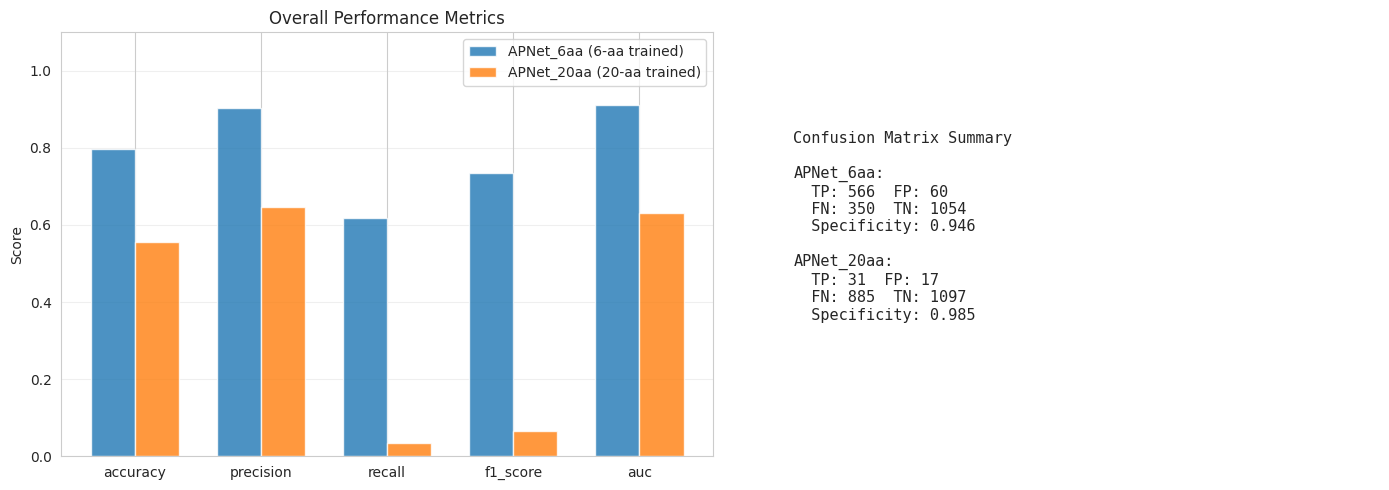

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Key metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
x = np.arange(len(metrics))
width = 0.35

ax1 = axes[0]
vals_6aa = [overall_df[overall_df['model'] == 'APNet_6aa'][m].values[0] for m in metrics]
vals_20aa = [overall_df[overall_df['model'] == 'APNet_20aa'][m].values[0] for m in metrics]

ax1.bar(x - width/2, vals_6aa, width, label='APNet_6aa (6-aa trained)', alpha=0.8)
ax1.bar(x + width/2, vals_20aa, width, label='APNet_20aa (20-aa trained)', alpha=0.8)

ax1.set_ylabel('Score')
ax1.set_title('Overall Performance Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Confusion matrices
ax2 = axes[1]
ax2.axis('off')

# Create text summary
summary_text = "Confusion Matrix Summary\n\n"
for idx, row in overall_df.iterrows():
    summary_text += f"{row['model']}:\n"
    summary_text += f"  TP: {row['true_pos']:.0f}  FP: {row['false_pos']:.0f}\n"
    summary_text += f"  FN: {row['false_neg']:.0f}  TN: {row['true_neg']:.0f}\n"
    summary_text += f"  Specificity: {row['specificity']:.3f}\n\n"

ax2.text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
         verticalalignment='center')

plt.tight_layout()
plt.savefig('./CPAD2_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Performance by Length Visualization

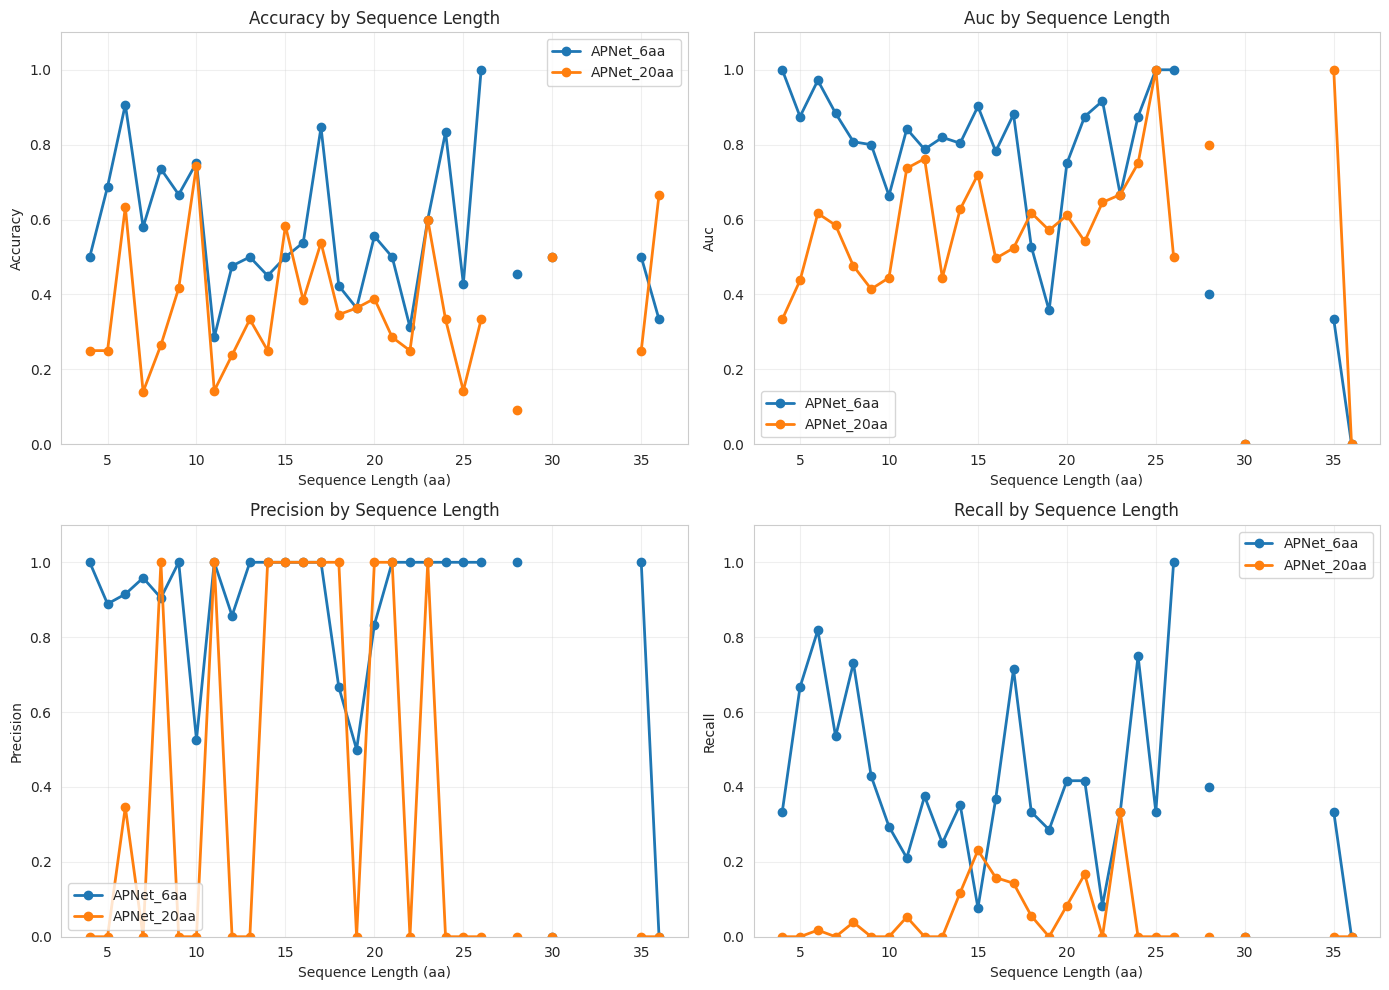

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['accuracy', 'auc', 'precision', 'recall']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    for model_name in ['APNet_6aa', 'APNet_20aa']:
        data = length_combined[length_combined['model'] == model_name]
        ax.plot(data['length'], data[metric], marker='o', label=model_name, linewidth=2)
    
    ax.set_xlabel('Sequence Length (aa)')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} by Sequence Length')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('./CPAD2_length_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. ROC Curves Comparison

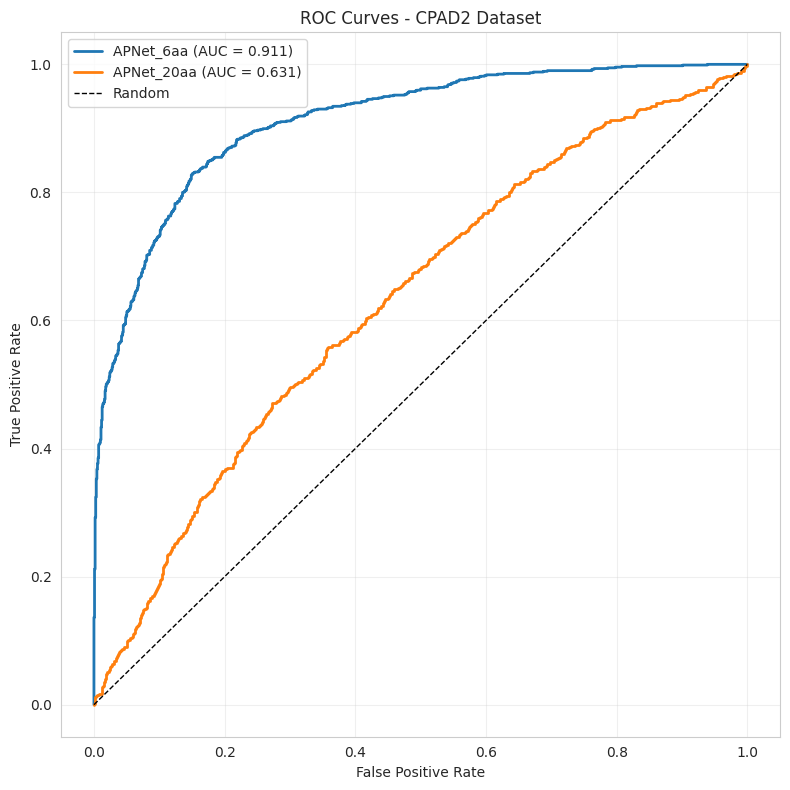

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for model_name, df in [('APNet_6aa', merge_6aa), ('APNet_20aa', merge_20aa)]:
    fpr, tpr, _ = roc_curve(df['label'], df['probability'])
    auc = roc_auc_score(df['label'], df['probability'])
    ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - CPAD2 Dataset')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./CPAD2_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Statistical Comparison

In [28]:
print("\n" + "="*70)
print("PERFORMANCE DIFFERENCES (APNet_20aa - APNet_6aa)")
print("="*70)

diff_df = overall_df.copy()
if len(diff_df) == 2:
    metrics_diff = ['accuracy', 'precision', 'recall', 'f1_score', 'auc', 'specificity']
    
    print("\nOverall differences:")
    for metric in metrics_diff:
        val_6aa = diff_df[diff_df['model'] == 'APNet_6aa'][metric].values[0]
        val_20aa = diff_df[diff_df['model'] == 'APNet_20aa'][metric].values[0]
        diff = val_20aa - val_6aa
        pct_diff = (diff / val_6aa * 100) if val_6aa != 0 else 0
        print(f"  {metric:15s}: {diff:+.4f} ({pct_diff:+.1f}%)")


PERFORMANCE DIFFERENCES (APNet_20aa - APNet_6aa)

Overall differences:
  accuracy       : -0.2424 (-30.4%)
  precision      : -0.2583 (-28.6%)
  recall         : -0.5841 (-94.5%)
  f1_score       : -0.6698 (-91.2%)
  auc            : -0.2801 (-30.7%)
  specificity    : +0.0386 (+4.1%)


## 11. Export Results

In [29]:
# Export combined results
combined_results = pd.concat([
    merge_6aa.assign(model='APNet_6aa'),
    merge_20aa.assign(model='APNet_20aa')
])

combined_results.to_csv('./CPAD2_combined_predictions.csv', index=False)
print(f"Saved combined predictions to ./CPAD2_combined_predictions.csv")

# Export summary tables
overall_df.to_csv('./CPAD2_overall_metrics.csv', index=False)
length_combined.to_csv('./CPAD2_length_stratified_metrics.csv', index=False)

print("\nSaved summary tables:")
print("  - ./CPAD2_overall_metrics.csv")
print("  - ./CPAD2_length_stratified_metrics.csv")

Saved combined predictions to ./CPAD2_combined_predictions.csv

Saved summary tables:
  - ./CPAD2_overall_metrics.csv
  - ./CPAD2_length_stratified_metrics.csv


## 12. Summary and Conclusions

In [30]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"""
Dataset: CPAD2 (Aggregating Peptides)
Total samples: {len(CPAD2_df)}
Sequence length range: {CPAD2_df['length'].min()}-{CPAD2_df['length'].max()} aa

Models Compared:
1. APNet_6aa: Trained on 6-aa sequences
2. APNet_20aa: Trained on 20-aa sequences (Thompson dataset)

Key Findings:
""")

# Determine better model
auc_6aa = overall_df[overall_df['model'] == 'APNet_6aa']['auc'].values[0]
auc_20aa = overall_df[overall_df['model'] == 'APNet_20aa']['auc'].values[0]

if auc_20aa > auc_6aa:
    print(f"✓ APNet_20aa performs better overall (AUC: {auc_20aa:.3f} vs {auc_6aa:.3f})")
    print(f"  Improvement: {((auc_20aa - auc_6aa) / auc_6aa * 100):.1f}%")
else:
    print(f"✓ APNet_6aa performs better overall (AUC: {auc_6aa:.3f} vs {auc_20aa:.3f})")
    print(f"  Improvement: {((auc_6aa - auc_20aa) / auc_20aa * 100):.1f}%")

# Check length-specific performance
pivot = length_combined.pivot(index='length', columns='model', values='auc')
print("\nLength-specific AUC:")
print(pivot.to_string())

print("\nVisualizations saved:")
print("  - ./CPAD2_overall_comparison.png")
print("  - ./CPAD2_length_comparison.png")
print("  - ./CPAD2_roc_curves.png")


SUMMARY

Dataset: CPAD2 (Aggregating Peptides)
Total samples: 2031
Sequence length range: 3-83 aa

Models Compared:
1. APNet_6aa: Trained on 6-aa sequences
2. APNet_20aa: Trained on 20-aa sequences (Thompson dataset)

Key Findings:

✓ APNet_6aa performs better overall (AUC: 0.911 vs 0.631)
  Improvement: 44.4%

Length-specific AUC:
model   APNet_20aa  APNet_6aa
length                       
3              NaN        NaN
4         0.333333   1.000000
5         0.437500   0.875000
6         0.616608   0.971609
7         0.584718   0.883721
8         0.475962   0.807692
9         0.414286   0.800000
10        0.444742   0.663993
11        0.736842   0.842105
12        0.762500   0.787500
13        0.444444   0.819444
14        0.627451   0.803922
15        0.720280   0.902098
16        0.496241   0.781955
17        0.523810   0.880952
18        0.618056   0.527778
19        0.571429   0.357143
20        0.611111   0.750000
21        0.541667   0.875000
22        0.645833   0.916667
23   